In [41]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load training data from Google Drive
df = pd.read_csv('/content/drive/MyDrive/merged_data.csv')

# Load test data from Google Drive
test_df = pd.read_csv('/content/drive/MyDrive/review.csv')

# Column names of the dataset
user_col, name_col, rating_col = 'user_id', 'name', 'stars'

# Filter training data: Keep only users and items with minimum interactions
# Keep only users and items with at least 5 ratings
filtered_df = df.groupby(user_col).filter(lambda x: len(x) >= 5)
filtered_df = filtered_df.groupby(name_col).filter(lambda x: len(x) >= 5)

# Reduce dataset size: Limit to 10,000 rows to save memory
filtered_df = filtered_df.sample(n=10000, random_state=42)

# Convert user_id and name to numeric values
user_ids, user_names = pd.factorize(filtered_df[user_col])
name_ids, name_labels = pd.factorize(filtered_df[name_col])

ratings_data = filtered_df[rating_col].values.astype(np.int32)

# Create a CSR matrix for training data
ratings = csr_matrix(
    (ratings_data, (user_ids, name_ids)),
    shape=(len(np.unique(user_ids)), len(np.unique(name_ids)))
).toarray()

# Convert to DataFrame
user_item_matrix = pd.DataFrame(ratings, index=user_names, columns=name_labels)
print(user_item_matrix.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                        Apple Store  Nando's PERi-PERi  Tango  \
RW4VosmJhHtFzNIxxFRDNQ            1                  0      0   
Rpqf0uVt6XENIvrbaSciiA            0                  4      0   
TFw7YRiyl4r2nw3_JFh2Ww            0                  0      2   
_BcWyKQL16ndpBdggh2kNA            0                  0      0   
NAtkmn07-dNVA6YMqZCs6Q            0                  0      0   

                        Jules Thin Crust  Walden's Coffeehouse  Pizza Hut  \
RW4VosmJhHtFzNIxxFRDNQ                 0                     0          0   
Rpqf0uVt6XENIvrbaSciiA                 0                     0          0   
TFw7YRiyl4r2nw3_JFh2Ww                 0                     0          0   
_BcWyKQL16ndpBdggh2kNA                 5                     0          0   
NAtkmn07-dNVA6YMqZCs6Q                 0                     5          0   

                 

In [42]:


class MatrixFactorization():
    def __init__(self, ratings, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.non_zero_row_ind, self.non_zero_col_ind = ratings.nonzero()
        self.n_interac = len(ratings[np.where(ratings != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate  # eta0 Constant that multiplies the update term
        self.alpha = alpha  # lambda Constant that multiplies the regularization term
        self.n_iter = n_iter
        self.mse_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False

    def initialize(self):
        self.now = time.time()
        # Initialize Bias Values
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        # Initialize user & item vectors
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))
        # Compute global bias
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.evaluate_the_model(0)

    def predict(self, u, i):
        return self.global_bias + self.user_biases[u] + self.item_biases[i] + self.user_vecs[u] @ self.item_vecs[i]

    def update_biases_and_vectors(self, error, u, i):
        # Update biases
        self.user_biases[u] += self.l_rate * (error - self.alpha * self.user_biases[u])
        self.item_biases[i] += self.l_rate * (error - self.alpha * self.item_biases[i])
        # Update User and item Vectors
        self.user_vecs[u, :] += self.l_rate * (error * self.item_vecs[i, :] - self.alpha * self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate * (error * self.user_vecs[u, :] - self.alpha * self.item_vecs[i, :])

    def evaluate_the_model(self, epoch):
        tot_square_error = 0
        for index in self.ind_lst:
            # Extracting user item information indices in which we have a rating
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            tot_square_error += (self.ratings[u, i] - pred_rat) ** 2
        mse = tot_square_error / self.n_interac
        self.mse_lst.append(mse)
        if self.verbose:
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time() - self.now, 3)
            print(f"ave mse {np.round(self.mse_lst[-1], 3)} ===> Total training time: {temp} seconds.")

    def early_stopping(self, epoch):
        if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
            if self.wait == self.n_iter_no_change:
                temp = np.round(time.time() - self.now, 3)
                if self.verbose: print(f"Convergence after {epoch} epochs time took: {temp} seconds.")
                self.stop = True
                self.conv_epoch_num = epoch
            self.wait += 1
        else:
            self.wait = 0

    def fit(self):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if not self.stop:
                for index in self.ind_lst:
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    error = self.ratings[u, i] - pred_rat
                    self.update_biases_and_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.early_stopping(epoch)
        self.conv_epoch_num = epoch
        self.plot_the_score()

    def result(self):
        return self.user_vecs, self.item_vecs

    def plot_the_score(self):
        plt.figure(figsize=(18, 6))
        plt.plot(range(1, 1 + len(self.mse_lst)), self.mse_lst, marker='o')
        plt.title("Training MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('Mean square error', fontsize=18)
        plt.xticks(range(1, self.conv_epoch_num + 5), fontsize=15, rotation=90)
        plt.yticks(np.linspace(min(self.mse_lst), max(self.mse_lst), 15), fontsize=15)
        plt.grid()
        plt.show()

---> Epoch 0
ave mse 1.957 ===> Total training time: 0.172 seconds.
---> Epoch 1
ave mse 1.806 ===> Total training time: 0.425 seconds.
---> Epoch 2
ave mse 1.705 ===> Total training time: 0.685 seconds.
---> Epoch 3
ave mse 1.626 ===> Total training time: 0.926 seconds.
---> Epoch 4
ave mse 1.557 ===> Total training time: 1.176 seconds.
---> Epoch 5
ave mse 1.497 ===> Total training time: 1.418 seconds.
---> Epoch 6
ave mse 1.442 ===> Total training time: 1.754 seconds.
---> Epoch 7
ave mse 1.391 ===> Total training time: 2.178 seconds.
---> Epoch 8
ave mse 1.344 ===> Total training time: 2.609 seconds.
---> Epoch 9
ave mse 1.3 ===> Total training time: 3.048 seconds.
---> Epoch 10
ave mse 1.258 ===> Total training time: 3.491 seconds.
---> Epoch 11
ave mse 1.219 ===> Total training time: 3.939 seconds.
---> Epoch 12
ave mse 1.181 ===> Total training time: 4.36 seconds.
---> Epoch 13
ave mse 1.146 ===> Total training time: 4.774 seconds.
---> Epoch 14
ave mse 1.112 ===> Total training

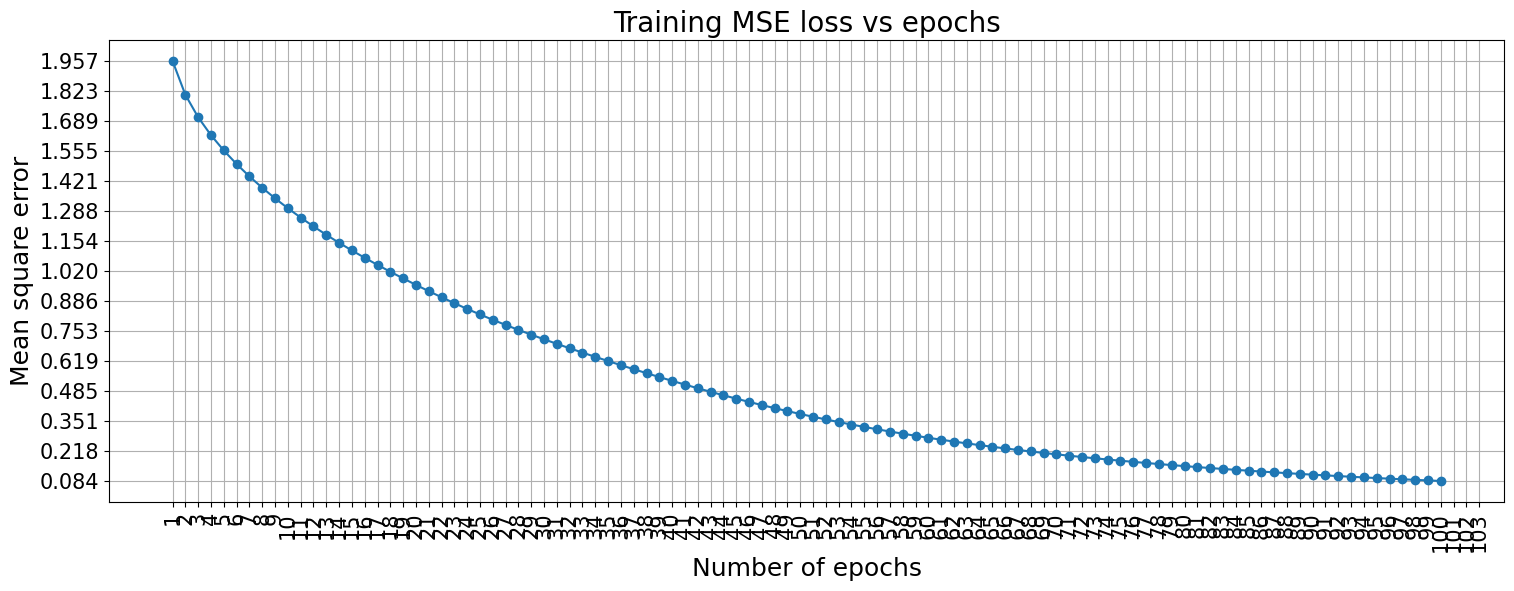

Test RMSE: 1.7223695797195888

Top 3 recommendations for user 5215:
Restaurant: Fatdogs, Predicted Rating: 6.02938761690172
Restaurant: Strange Donuts, Predicted Rating: 5.996820207143812
Restaurant: Ruby Buffet, Predicted Rating: 5.925621389542761


In [43]:
# 모델 초기화 및 학습
obj = MatrixFactorization(ratings)
obj.fit()

user_vecs, item_vecs = obj.result()

# 테스트 데이터 준비
test_user_ids, _ = pd.factorize(test_df[user_col])
test_item_ids, _ = pd.factorize(test_df[name_col])
test_ratings = pd.to_numeric(test_df[rating_col], errors='coerce').fillna(0).values

# 테스트 세트에 대한 예측 계산
predictions = [
    obj.predict(test_user_ids[i], test_item_ids[i])
    if (test_user_ids[i] < len(user_vecs) and test_item_ids[i] < len(item_vecs))
    else np.nan
    for i in range(len(test_user_ids))
]

# 테스트 세트에 대한 예측 평가
test_df['predicted_rating'] = predictions
mse = ((pd.to_numeric(test_df[rating_col], errors='coerce') - test_df['predicted_rating']) ** 2).mean()
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

# 랜덤 사용자 선택 후 상위 3개 추천 항목 출력
random_user = np.random.choice(test_user_ids)
item_scores = [(i, obj.predict(random_user, i)) for i in range(len(item_vecs))]
item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

print("\nTop 3 recommendations for user {}:".format(random_user))
for idx, score in item_scores[:3]:
    print(f"Restaurant: {name_labels[idx]}, Predicted Rating: {score}")

In [44]:
# 아이템 유사도 계산
ame_similarity_matrix = cosine_similarity(item_vecs)

name_similarity_df = pd.DataFrame(ame_similarity_matrix, index=name_labels, columns=name_labels)

# 결과 데이터프레임 생성
result_df = pd.DataFrame(ame_similarity_matrix, index=name_labels, columns=name_labels)
result_df


,Apple Store,Nando's PERi-PERi,Tango,Jules Thin Crust,Walden's Coffeehouse,Pizza Hut,Imo's Pizza,Walmart Supercenter,XIX Nineteen,Jockamo Upper Crust Pizza,...,DoubleTree by Hilton Hotel Philadelphia Airport,The Donut + Dog,Sesame Chinese Restaurant,Frank's Pizza,Aman's Indian Bistro,Alfred Angelo Bridal,Dollarama,United Parcel Service,Back Bar,Solar Nails & Spa
Apple Store,1.000000,-0.072636,0.153054,-0.058697,-0.091740,-0.155789,-0.164996,0.047634,-0.070215,0.167674,...,-0.121461,-0.065476,0.126846,-0.116859,0.047373,0.117275,0.068553,0.063861,-0.106467,0.107387
Nando's PERi-PERi,-0.072636,1.000000,-0.020763,0.005140,0.140818,-0.191012,-0.052751,0.151085,-0.093075,-0.062337,...,-0.073220,0.102148,-0.071458,-0.032270,0.114871,0.127541,-0.024739,0.160795,-0.036122,-0.227957
Tango,0.153054,-0.020763,1.000000,-0.068517,0.164414,-0.030570,-0.107355,-0.059778,0.103483,0.086521,...,-0.047791,-0.081441,0.095254,0.098449,0.012645,0.131996,0.119583,0.045929,-0.040360,0.199608
Jules Thin Crust,-0.058697,0.005140,-0.068517,1.000000,-0.154466,0.207100,-0.085122,0.211881,0.107235,0.092857,...,-0.005467,-0.012941,0.118232,-0.121503,0.131189,-0.126203,0.048487,0.050279,-0.057916,-0.000860
Walden's Coffeehouse,-0.091740,0.140818,0.164414,-0.154466,1.000000,0.033788,0.157230,0.027807,-0.061036,-0.016483,...,0.025231,0.050769,0.018190,0.040948,-0.157401,0.126528,0.010402,-0.010530,0.109255,-0.085163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Alfred Angelo Bridal,0.117275,0.127541,0.131996,-0.126203,0.126528,-0.074333,0.038754,-0.011885,-0.034590,0.063665,...,-0.048574,0.060972,0.049692,0.114473,0.214847,1.000000,0.049827,-0.000656,-0.020363,0.226801
Dollarama,0.068553,-0.024739,0.119583,0.048487,0.010402,-0.058886,0.032876,0.093379,-0.081609,0.077252,...,-0.003803,0.054861,0.003249,0.050850,-0.161139,0.049827,1.000000,0.108527,-0.011616,-0.034438
United Parcel Service,0.063861,0.160795,0.045929,0.050279,-0.010530,-0.200863,-0.176946,0.031462,-0.074407,0.154388,...,-0.189708,0.041447,-0.065496,0.029045,0.066862,-0.000656,0.108527,1.000000,0.029994,0.047373
Back Bar,-0.106467,-0.036122,-0.040360,-0.057916,0.109255,0.195856,0.119415,0.074692,-0.056946,-0.031173,...,0.018971,0.080119,-0.115759,0.250048,-0.024597,-0.020363,-0.011616,0.029994,1.000000,0.030733
